# Training and Inference of CIFAR 10 using Pytorch Lightning on AWS SageMaker
## Requirements Installation

In [30]:
!pip install torch torchsummary gradio pytorch-lightning torch-lr-finder albumentations grad_cam -q

In [61]:
!pip install tensorboard -q

In [62]:
!pip install sagemaker -U -q

## Import Modules

In [33]:
# Import all the required modules
import os
import math
import sys
import numpy as np
import albumentations as A
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from albumentations.pytorch import ToTensorV2
from torch_lr_finder import LRFinder
from pytorch_lightning.callbacks import ModelSummary, LearningRateMonitor, ModelCheckpoint, LearningRateFinder
from resnetS11 import LITResNet
from pytorch_lightning import Trainer

from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

## Model Training Parameters

In [34]:
SEED = 48
EPOCHS = 24
BATCH_SIZE = 512

## The Model

In [35]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

model = LITResNet(classes)
model

LITResNet(
  (inv_normalize): Normalize(mean=[-2.1739130434782608, -2.1739130434782608, -2.1739130434782608], std=[4.3478260869565215, 4.3478260869565215, 4.3478260869565215])
  (accuracy): MulticlassAccuracy()
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, mome

## Data Statistics

Files already downloaded and verified
Files already downloaded and verified
[Train]
 - Total Train Images: 50000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49139968, 0.48215827, 0.44653124)
 - std: (0.24703233, 0.24348505, 0.26158768)
 - var: (0.061024975, 0.05928497, 0.06842812)
[Test]
 - Total Test Images: 10000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49421427, 0.48513183, 0.45040932)
 - std: (0.24665256, 0.24289224, 0.26159248)
 - var: (0.06083748, 0.058996636, 0.06843062)


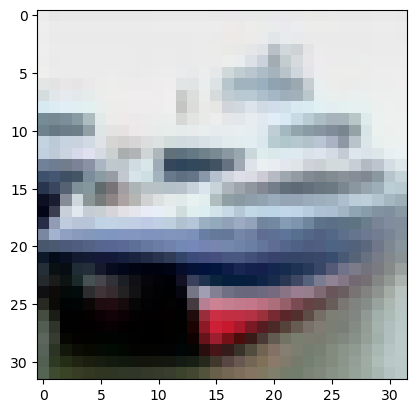

In [36]:
model.get_statistics()
model.get_statistics(data_set_type="Test")

## Visualize Training Data

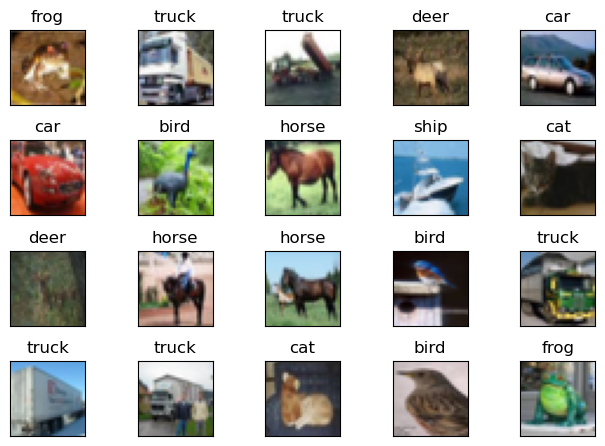

In [37]:
model.display_data_samples()

## Visualize Augmentations

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


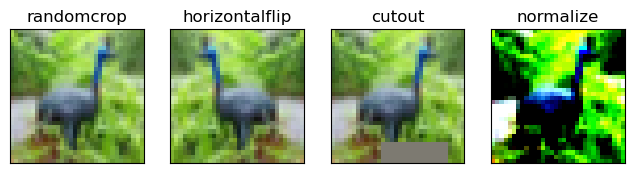

In [38]:
aug_set_transforms = {
    'randomcrop': A.RandomCrop(height=32, width=32, p=1),
    'horizontalflip': A.HorizontalFlip(p=1),
    'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=(0.49139968*255, 0.48215827*255, 0.44653124*255), mask_fill_value=None, p=1),
    'normalize': A.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2(),
}

model.visualize_augmentation(aug_set_transforms)


## Transformations

In [39]:
# Train Phase transformations
train_set_transforms = {
    'randomcrop': A.RandomCrop(height=32, width=32, p=0.2),
    'horizontalflip': A.HorizontalFlip(),
    'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=[0.49139968*255, 0.48215827*255 ,0.44653124*255], mask_fill_value=None),
    'normalize': A.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2(),
}

# Test Phase transformations
test_set_transforms = {
    'normalize': A.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2()
}

# Set transformations for training and test dataset
model.set_transforms(train_set_transforms, test_set_transforms)

## LR Finder

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.26E-02


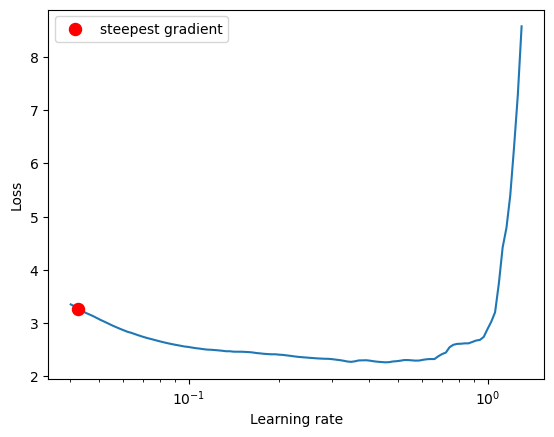

In [40]:
# LR finder
model.setup()
model.prepare_data()

optimizer = optim.Adam(model.parameters(), lr=model._learning_rate, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(model.train_dataloader(), end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [41]:
model._learning_rate = 4.26E-02

## Model Training and Testing

In [42]:
# Monitor Learning rate while training to verify correct implementation of OCP
lr_monitor = LearningRateMonitor(logging_interval="epoch")

# Save the last best model based on validation loss
checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min',
)

# Define trainer for model training
trainer = Trainer(
    callbacks=[ModelSummary(max_depth=-1), lr_monitor, checkpoint_callback],
    max_epochs = EPOCHS,
    check_val_every_n_epoch=1,
    num_sanity_val_steps=1
)

# Train the Model
trainer.fit(model)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params
------------------------------------------------------------
0  | inv_normalize       | Normalize          | 0     
1  | accuracy            | MulticlassAccuracy | 0     
2  | conv1               | Conv2d             | 1.7 K 
3  | bn1                 | BatchNorm2d        | 128   
4  | layer1              | Sequential         | 147 K 
5  | layer1.0            | BasicBlock         | 74.0 K
6  | layer1.0.conv1      | Conv2d             | 36.9 K
7  | layer1.0.bn1        | BatchNorm2d        | 128   
8  | layer1.0.conv2      | Conv2d             | 36.9 K
9  | layer1.0.bn2        | BatchNorm2d        | 128   
10 | layer1.0.shortcut   | Sequential         | 0     
11 | layer1.1            | BasicBlock         | 74.0 K
12 | layer1.1.conv1      | Conv2d             | 36.9 K
13 | layer1.1.bn1        | BatchNorm2d        | 128   
14 | layer1.1.conv2      | Conv2d             | 36.9 K
15 | layer1.1.bn

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 88: 'val_loss' reached -3.83905 (best -3.83905), saving model to '/home/ec2-user/SageMaker/lightning_logs/version_2/checkpoints/epoch=0-step=88.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 176: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 264: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 352: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 440: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 528: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 616: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 704: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 792: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 880: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 968: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 1056: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 1144: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 1232: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 1320: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 1408: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 1496: 'val_loss' reached -4.48738 (best -4.48738), saving model to '/home/ec2-user/SageMaker/lightning_logs/version_2/checkpoints/epoch=16-step=1496.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 1584: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 1672: 'val_loss' reached -4.55049 (best -4.55049), saving model to '/home/ec2-user/SageMaker/lightning_logs/version_2/checkpoints/epoch=18-step=1672.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1760: 'val_loss' reached -5.58175 (best -5.58175), saving model to '/home/ec2-user/SageMaker/lightning_logs/version_2/checkpoints/epoch=19-step=1760.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1848: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1936: 'val_loss' reached -5.96343 (best -5.96343), saving model to '/home/ec2-user/SageMaker/lightning_logs/version_2/checkpoints/epoch=21-step=1936.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 2024: 'val_loss' reached -6.69782 (best -6.69782), saving model to '/home/ec2-user/SageMaker/lightning_logs/version_2/checkpoints/epoch=22-step=2024.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 2112: 'val_loss' reached -7.46363 (best -7.46363), saving model to '/home/ec2-user/SageMaker/lightning_logs/version_2/checkpoints/epoch=23-step=2112.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=24` reached.


In [43]:
trainer.validate()

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /home/ec2-user/SageMaker/lightning_logs/version_2/checkpoints/epoch=23-step=2112.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ec2-user/SageMaker/lightning_logs/version_2/checkpoints/epoch=23-step=2112.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8827999830245972     │
│         val_loss          │     -7.45644474029541     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': -7.45644474029541, 'val_acc': 0.8827999830245972}]

In [44]:
trainer.test()

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /home/ec2-user/SageMaker/lightning_logs/version_2/checkpoints/epoch=23-step=2112.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ec2-user/SageMaker/lightning_logs/version_2/checkpoints/epoch=23-step=2112.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8888999819755554     │
│         val_loss          │     -7.91683292388916     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': -7.91683292388916, 'val_acc': 0.8888999819755554}]

## Save/Load Model

In [46]:
model_dir = '/home/ec2-user/SageMaker/data/3'

#Save the model
trainer.save_checkpoint(os.path.join(model_dir,"model.pth"))
print(model.state_dict().keys())
print(type(model))


odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

## Model Inference

In [47]:
def predict_image(image_path):
  classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
            'dog', 'frog', 'horse', 'ship', 'truck']

  # Load the JPG image
  input_img = Image.open(image_path).resize((32,32))

  # Convert img to tensor and normalize it
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768)),
  ])

  # Apply the transforms on the input image
  input_img = transform(input_img).unsqueeze(0)

  # Load the PyTorch model
  model = LITResNet(classes)  # Replace YourModelClass with the actual class name of your model
  model.load_state_dict(torch.load(os.path.join(model_dir, "model.pth"))["state_dict"])
  model.eval()  # Set the model to evaluation mode

  # Perform inference
  with torch.no_grad():
      output = model(input_img)

  predicted_class_index = torch.argmax(output,dim=1)
  predicted_class_name = classes[predicted_class_index[0]]

  # Display the input image
  plt.subplot(1, 2, 1)
  plt.imshow(input_img.squeeze().permute(1, 2, 0))  # Convert tensor back to numpy array and permute dimensions
  plt.title('Input Image')

  # Display the output image with the predicted class label
  plt.subplot(1, 2, 2)
  plt.imshow(input_img.squeeze().permute(1, 2, 0))  # Convert tensor back to numpy array and permute dimensions
  plt.title('Predicted Class: ' + predicted_class_name)

  plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


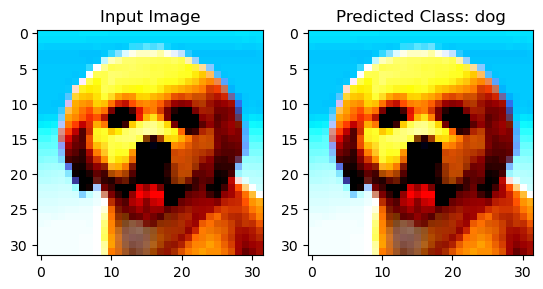

In [50]:
predict_image('/home/ec2-user/SageMaker/dog.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


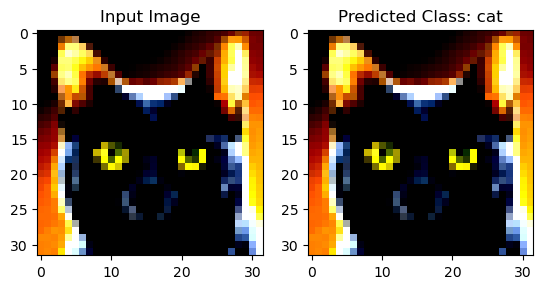

In [51]:
predict_image('/home/ec2-user/SageMaker/cat.jpg')

In [52]:
torch.load(os.path.join(model_dir, "model.pth")).keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])

In [ ]:
# from pytorch_lightning.tuner import Tuner
# import matplotlib.pyplot as plt
# # Train the model
# #trainer.fit(model)
# from pytorch_lightning import Trainer
# trainer = Trainer(max_epochs=24)  # Train for 1 epoch
# tuner = Tuner(trainer)

# # Run learning rate finder
# lr_finder = tuner.lr_find(model)

# # Results can be found in
# print(lr_finder.results)

# # Plot with matplotlib
# fig = lr_finder.plot(suggest=True)
# fig.show()
# plt.show()  # Show the plot inline

# # Pick point based on plot, or get suggestion
# new_lr = lr_finder.suggestion()

# # update hparams of the model
# model.hparams.lr = new_lr

## Gradio